In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [20]:
# Define the generator model
class Generator(nn.Module):
    def __init__(self, input_size, output_size, hidden_size=128):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
        )

    def forward(self, x):
        return self.model(x)

# Define the discriminator model
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size=128):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.model(x)

# Define the GAN model
class GAN(nn.Module):
    def __init__(self, input_size_g, output_size_g, input_size_d, hidden_size_d=128):
        super(GAN, self).__init__()
        self.generator = Generator(input_size_g, output_size_g)
        self.discriminator = Discriminator(input_size_d, hidden_size_d)

    def forward(self, x):
        x = self.generator(x)
        x = self.discriminator(x)
        return x
    
# Custom dataset class
class OdorDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # sample = self.data.iloc[idx][["xsrc", "ysrc", "odor", "corrected_u", "corrected_v"]]
        sample = self.data.iloc[idx][["windx", "windy", "x", "y", "scaled_odor"]]
        return torch.tensor(sample.values, dtype=torch.float32)

In [21]:
# Load and preprocess data
# dir = '~/DataAnalysis/data/Sprints/HighRes/'
# data = pd.read_hdf(dir+'Windy/WindyMASigned.h5') # Replace with your data file
data = pd.read_hdf('~/DataAnalysis/data/generated_data_plume_sim/train_2/train.h5')

In [16]:
# # # new_data=data[:30000]
# data

In [26]:
dataset = OdorDataset(data)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Initialize GAN, optimizer, and loss function
input_size_g = 4  # xsrc, ysrc, wind_velocity_U, and wind_velocity_V
output_size_g = 1  # New odor measurement
input_size_d = 5  # xsrc, ysrc, odor, wind_velocity_U, and wind_velocity_V

gan = GAN(input_size_g, output_size_g, input_size_d)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
gan.to(device)

optimizer = optim.Adam(gan.parameters(), lr=0.001)
criterion = nn.BCELoss()

##  # Assuming 'data' is a DataFrame with features and target
# features = torch.tensor(data[features].values, dtype=torch.float32)
# targets = torch.tensor(data[target].values, dtype=torch.float32)
# dataset = TensorDataset(features, targets)
# dataloader = DataLoader(dataset, batch_size=32, shuffle=True)



In [27]:
num_epochs = 50
for epoch in range(num_epochs):
    for i, real_data in enumerate(dataloader):
        real_data = real_data.to(device)
        input_gen = real_data[:, [0, 1, 3, 4]]

        generated_odor = gan.generator(input_gen)
        fake_data = torch.cat((input_gen[:, :2], generated_odor, input_gen[:, 2:]), dim=1)

        real_labels = torch.ones(real_data.size(0), 1).to(device)
        fake_labels = torch.zeros(fake_data.size(0), 1).to(device)

        optimizer.zero_grad()

        real_outputs = gan.discriminator(real_data)
        real_loss = criterion(real_outputs, real_labels)

        fake_outputs = gan.discriminator(fake_data.detach())
        fake_loss = criterion(fake_outputs, fake_labels)

        d_loss = real_loss + fake_loss
        d_loss.backward()
        optimizer.step()

        optimizer.zero_grad()

        fake_outputs = gan.discriminator(fake_data)
        g_loss = criterion(fake_outputs, real_labels)

        g_loss.backward()
        optimizer.step()

    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], d_loss: {d_loss.item()}, g_loss: {g_loss.item()}')
        fixed_noise = torch.randn(64, input_size_g).to(device)
        generated_samples = gan.generator(fixed_noise).detach().cpu().numpy()
        print(generated_samples)

Epoch [10/50], d_loss: 0.9520454406738281, g_loss: 3.470909595489502
[[ 8.53678162e+02]
 [ 6.26328308e+02]
 [ 1.01564087e+02]
 [ 4.49057884e+01]
 [ 2.81940002e+02]
 [ 1.00971024e+02]
 [-1.83550507e+02]
 [-6.18294334e+01]
 [ 8.20227661e+02]
 [ 1.67786636e+02]
 [ 2.58343750e+02]
 [ 1.55123825e+02]
 [ 3.31413727e+02]
 [ 2.78714783e+02]
 [ 1.11480782e+02]
 [ 7.05658020e+02]
 [ 7.60509766e+02]
 [-1.40968170e+02]
 [ 5.40126282e+02]
 [ 1.98917427e+01]
 [-1.54008057e+02]
 [ 1.04584297e+02]
 [ 9.75451416e+02]
 [ 7.15155396e+02]
 [ 3.11020294e+02]
 [ 4.95481964e+02]
 [ 7.09434052e+01]
 [ 3.56775909e+02]
 [ 7.95664062e+02]
 [ 6.08331909e+02]
 [ 1.29796094e+03]
 [ 4.27662018e+02]
 [ 1.27036407e+02]
 [ 2.22637833e+02]
 [ 3.25450226e+02]
 [ 8.42767273e+02]
 [ 6.82295349e+02]
 [ 7.35257019e+02]
 [-4.29599800e+01]
 [-1.14005470e+00]
 [-6.90786209e+01]
 [ 5.92931702e+02]
 [ 1.06795074e+02]
 [ 6.45308411e+02]
 [ 1.91528946e+02]
 [ 5.94195374e+02]
 [ 1.76935558e+01]
 [-5.25084305e+01]
 [ 5.56765686e+02]


In [61]:
# t_data=data[405000:410000]
t_data=pd.read_hdf('/home/flybot/DataAnalysis/data/generated_data_plume_sim/train_2/diag30.h5')

In [63]:
t_data=t_data[:300]

In [64]:
test_data = torch.tensor([
    t_data.x.values,
    t_data.y.values,
    t_data.windx.values,
    t_data.windy.values
], dtype=torch.float32).T  # Transpose to have the correct shape

test_data = test_data.to(device) 
generated_odor = gan.generator(test_data)

In [65]:
# test_data = torch.tensor([
#     t_data.xsrc.values,
#     t_data.ysrc.values,
#     t_data.corrected_u.values,
#     t_data.corrected_v.values
# ], dtype=torch.float32).T  # Transpose to have the correct shape


# generated_odor = gan.generator(test_data)
# # print(generated_odor)


In [66]:
def scale_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (((data - min_val) / (max_val - min_val)) * 10)

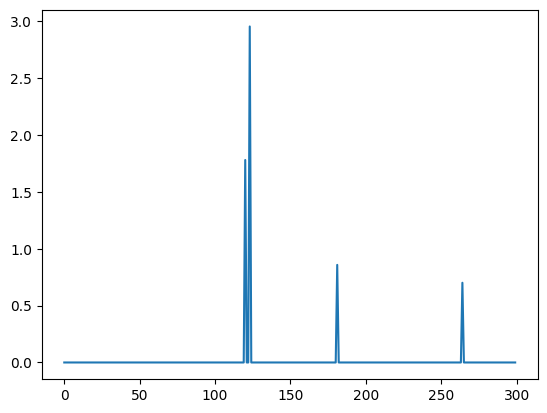

In [67]:
plt.plot(t_data.odor)

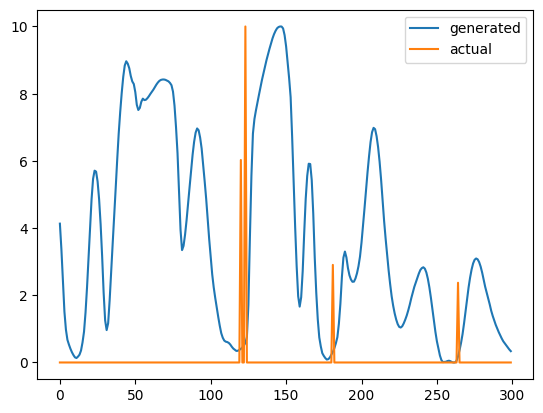

In [71]:
plt.plot(scale_data(generated_odor.cpu().detach().numpy()), label='generated')
plt.plot(scale_data(t_data.odor), label='actual')
plt.legend()
# plt.savefig('gan_on_sim.jpg')

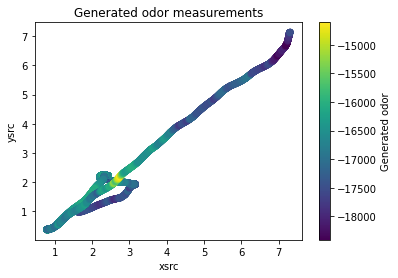

In [44]:
# Convert generated odor to NumPy array
generated_odor_np = generated_odor

# Get xsrc and ysrc values
xsrc_values = t_data.xsrc.values
ysrc_values = t_data.ysrc.values

# Create a scatter plot
plt.scatter(xsrc_values, ysrc_values, c=generated_odor_np, cmap='viridis', marker='o')
plt.colorbar(label='Generated odor')
plt.xlabel('xsrc')
plt.ylabel('ysrc')
plt.title('Generated odor measurements')
plt.show()

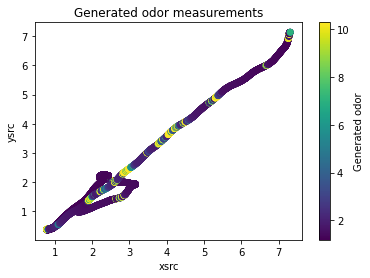

In [45]:
# Create a scatter plot
plt.scatter(xsrc_values, ysrc_values, c=t_data.odor, cmap='viridis', marker='o')
plt.colorbar(label='Generated odor')
plt.xlabel('xsrc')
plt.ylabel('ysrc')
plt.title('Generated odor measurements')
plt.show()